# Implement a CNN for CIFAR-10 (With Custom Layers)


The tasks was taken from: https://github.com/Exorust/TorchLeet/tree/main/torch/medium

## Problem Statement
You are tasked with implementing a **Convolutional Neural Network (CNN)** for image classification on the **CIFAR-10** dataset using PyTorch. However, instead of using PyTorch's built-in `nn.Conv2d` and `nn.MaxPool2d`, you must implement these layers **from scratch** using `nn.Module`. Your model will include convolutional layers for feature extraction, pooling layers for downsampling, and fully connected layers for classification.

### Requirements
1. **Implement Custom Layers:**
   - Create a custom `Conv2dCustom` class that mimics the behavior of `nn.Conv2d`.
   - Create a custom `MaxPool2dCustom` class that mimics the behavior of `nn.MaxPool2d`.
2. **Define the CNN Model:**
   - Use `Conv2dCustom` for convolutional layers.
   - Use `MaxPool2dCustom` for pooling layers.
   - Use standard `nn.Linear` for fully connected layers.
   - The model should process input images of shape `(3, 32, 32)` as in the CIFAR-10 dataset.

### Constraints
   - You must not use `nn.Conv2d` or `nn.MaxPool2d`. Use your own custom implementations.
   - The CNN should include multiple convolutional and pooling layers, followed by fully connected layers.
   - Ensure the model outputs class predictions for **10 classes**, as required by CIFAR-10.

**! Hint:**
   - Define `Conv2dCustom` and `MaxPool2dCustom` as subclasses of `nn.Module`. - Use nested loops and tensor slicing to perform the operations.
   - In `CNNModel.__init__`, use these custom layers to build the architecture.
   - Implement the forward pass to pass inputs through convolution, activation, pooling, flattening, and fully connected layers.


## Solution

### Rephrase

- Implement convolution and pooling - it involves intensive work with multidimensional tensors (`[batch, channels, height, width]`)
   - work with `view(), permute(), reshape(), transpose(), expand(), repeat()`
   - Implement complex indexing and slicing
- Initialization of scales
- Calculating gradients
- include multiple convolutional and pooling layers, followed by fully connected layers
- Ensure the model outputs class predictions for 10 classes, as required by CIFAR-10.

### Ideas behined

The key goal of this task is to break down the barrier between the "user" of a neural network and its "creator."

Using `nn.Conv2d` is the user level. You know what it does and can use it.

Implementing `Conv2dCustom` is the developer/researcher level. You know how it works and can create one from scratch. This transition is crucial for professional growth in Machine Learning.

So, even if you always use built-in modules in real work, this experience will give you invaluable insights that will help you debug models more effectively, design new architectures, and gain a deeper understanding of the underlying processes.

### Implementing note

- Formally nn.Conv2d uses Cross-correlation, so we are not going to rotate the core matrix

## Solution Code

### Very Naive Code Attempt (with loops)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Conv2dCustom(nn.Module):
  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    kernel_size: tuple[int, int] = (1, 1),
    stride: tuple[int, int] = (1, 1),
    padding: tuple[int, int] = (0, 0),
    dilation: tuple[int, int] = (1, 1),
    bias: bool = True,
  ):
    super().__init__()

    # save hyperparams
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dilation = dilation

    # init weights
    # https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
    self.weight = nn.Parameter(
        torch.Tensor(out_channels, in_channels, kernel_size[0], kernel_size[1])
        )

    if bias:
        self.bias = nn.Parameter(torch.Tensor(out_channels))
    else:
        self.register_parameter('bias', None)

    # Init weight by Kaiming Uniform (same as in PyTorch), by logic it's Xavier
    nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    # init bias
    if self.bias is not None:
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

  def add_padding(self, input_tensor):
    padding = self.padding
    if  padding == (0, 0):
      return input_tensor

    if len(padding) == 4:
      return F.pad(input_tensor, padding, mode='constant', value=0)

    pad_height, pad_width = padding
    # F.pad expects to be filled in the format: [left, right, top, bottom]
    padding_tuple = (pad_width, pad_width, pad_height, pad_height)

    return F.pad(input_tensor, padding_tuple, mode='constant', value=0)

  def calculate_output_size(self, input_size):
    # output_size = floor((input_size + 2*padding - dilation*(kernel_size-1) - 1) / stride + 1)
    def calc_dim(input_dim, kernel, stride, pad, dil):
        return (input_dim + 2 * pad - dil * (kernel - 1) - 1) // stride + 1

    # expand values
    height, width = input_size
    kernel_h, kernel_w = self.kernel_size
    stride_h, stride_w = self.stride
    pad_h, pad_w = self.padding
    dilation_h, dilation_w = self.dilation

    out_h = calc_dim(height, kernel_h, stride_h, pad_h, dilation_h)
    out_w = calc_dim(width, kernel_w, stride_w, pad_w, dilation_w)
    return out_h, out_w

  def create_output_tensor(self, input_tensor):
    batch_size = input_tensor.shape[0]
    input_height, input_width = input_tensor.shape[2], input_tensor.shape[3]
    output_size = self.calculate_output_size(input_size=(input_height, input_width))

    out_height, out_width = output_size

    # create a tensor with a normal shape and on the same device
    return torch.empty(
        batch_size,
        self.out_channels,
        out_height,
        out_width,
        device=input_tensor.device,
        dtype=input_tensor.dtype
    )

  def conv_implementation(self, x_padded, output):
    in_channels = self.in_channels
    batch_size, _, in_height, in_width = x_padded.shape
    kernel_h, kernel_w = self.kernel_size
    stride_h, stride_w = self.stride

    out_height = output.shape[2]
    out_width = output.shape[3]

    for oc in range(self.out_channels):
    #for b in range(batch_size):
        for b in range(batch_size):
       #for oc in range(self.out_channels):
          for oh in range(out_height):
              for ow in range(out_width):
                # Calculate the starting position of the window in the input tensor
                h_start = oh * stride_h
                w_start = ow * stride_w
                h_end = h_start + kernel_h
                w_end = w_start + kernel_w

                # Extracting a window from the input tensor
                window = x_padded[b, :, h_start:h_end, w_start:w_end] # window shape: [in_channels, kernel_h, kernel_w]

                # We get the weights for the current output channel
                weights = self.weight[oc]  # shape: [in_channels, kernel_h, kernel_w]

                # Convolution calculation - element-wise multiplication and summation of all elements of the resulting tensor
                result = torch.sum(window* weights)
                output[b, oc, oh, ow] = result

    return output


  def forward(self, x):
      x_padded = self.add_padding(x) # 1. Add padding
      output = self.create_output_tensor(x) # 2. Calculate size of the output tensor and prepare it
      output = self.conv_implementation(x_padded, output) # 3. Custom convolution

      if self.bias is not None:
        output += self.bias.view(1, -1, 1, 1)

      return output


### Test the naive Conv2DCustom

**Direct comparison using one example**

In [67]:
def test_conv_equivalence(bias=True):
    in_ch, out_ch = 3, 16
    kernel_size = (3, 3)
    stride = (2, 2)
    padding = (1, 1)
    batch_size = 16

    conv_standard = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
    conv_custom = Conv2dCustom(in_ch, out_ch, kernel_size, stride, padding, bias=bias)

    with torch.no_grad():
        conv_custom.weight.copy_(conv_standard.weight)
        if bias:
            conv_custom.bias.copy_(conv_standard.bias)

    x = torch.randn(batch_size, in_ch, 32, 32)

    with torch.no_grad():
        output_standard = conv_standard(x)
        output_custom = conv_custom(x)

    print(f"Bias: {bias}")
    print(f"Output shapes - Standard: {output_standard.shape}, Custom: {output_custom.shape}")
    print(f"Max difference: {torch.max(torch.abs(output_standard - output_custom))}")

    is_close = torch.allclose(output_standard, output_custom, atol=1e-6)
    print(f"✅ Success! Outputs are closed" if is_close else "❌ Fail! Outputs are not closed")
    #return is_close

# Тестируем оба варианта
test_conv_equivalence(bias=False)
print("\n")
test_conv_equivalence(bias=True)

Bias: False
Output shapes - Standard: torch.Size([16, 16, 16, 16]), Custom: torch.Size([16, 16, 16, 16])
Max difference: 5.960464477539062e-07
✅ Success! Outputs are closed


Bias: True
Output shapes - Standard: torch.Size([16, 16, 16, 16]), Custom: torch.Size([16, 16, 16, 16])
Max difference: 5.960464477539062e-07
✅ Success! Outputs are closed


# Gradients tests

In [69]:
def test_gradients(bias=True):
    in_ch, out_ch = 3, 16
    kernel_size = (3, 3)
    stride = (2, 2)
    padding = (1, 1)
    batch_size = 16

    print(f"Bias: {bias}")

    conv_standard = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
    conv_custom = Conv2dCustom(in_ch, out_ch, kernel_size, stride, padding, bias=bias)

    with torch.no_grad():
        conv_custom.weight.copy_(conv_standard.weight)
        if bias:
            conv_custom.bias.copy_(conv_standard.bias)

    x = torch.randn(batch_size, in_ch, 32, 32, requires_grad=True)
    with torch.no_grad():
        test_output = conv_standard(x)
        output_shape = test_output.shape

    print(f"Output shape: {output_shape}")

    target = torch.randn(output_shape)

    criterion = nn.MSELoss()

    # Test Pytorch implementation
    output_std = conv_standard(x)
    loss_std = criterion(output_std, target)
    loss_std.backward()
    grad_std = x.grad.clone()
    weight_grad_std = conv_standard.weight.grad.clone()

    # Reset gradients
    x.grad = None
    conv_standard.weight.grad = None

    # Test Custom implementation
    output_custom = conv_custom(x)
    loss_custom = criterion(output_custom, target)
    loss_custom.backward()
    grad_custom = x.grad.clone()
    weight_grad_custom = conv_custom.weight.grad.clone()

    # Compare gradients
    print("Input gradients:")
    print(f"Max difference: {torch.max(torch.abs(grad_std - grad_custom))}")
    print(f"Gradients close: {torch.allclose(grad_std, grad_custom, atol=1e-6)}")

    print("\nGradients by weights:")
    print(f"Max difference: {torch.max(torch.abs(weight_grad_std - weight_grad_custom))}")
    print(f"Gradients close: {torch.allclose(weight_grad_std, weight_grad_custom, atol=1e-6)}")


test_gradients(bias=False)
print("\n")
test_gradients(bias=True)

Bias: False
Output shape: torch.Size([16, 16, 16, 16])
Input gradients:
Max difference: 5.093170329928398e-11
Gradients close: True

Gradients by weights:
Max difference: 6.332993507385254e-08
Gradients close: True


Bias: True
Output shape: torch.Size([16, 16, 16, 16])
Input gradients:
Max difference: 5.093170329928398e-11
Gradients close: True

Gradients by weights:
Max difference: 6.705522537231445e-08
Gradients close: True


### Testing and small code improvements

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Conv2dCustom(nn.Module):
  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    kernel_size: tuple[int, int] = (1, 1),
    stride: tuple[int, int] = (1, 1),
    padding: tuple[int, int] = (0, 0),
    dilation: tuple[int, int] = (1, 1),
    bias: bool = True,
  ):
    super().__init__()

    if isinstance(kernel_size, int):
         kernel_size = (kernel_size, kernel_size)
    if isinstance(stride, int):
        stride = (stride, stride)
    if isinstance(padding, int):
        padding = (padding, padding)
    if isinstance(dilation, int):
        dilation = (dilation, dilation)

    # save hyperparams
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dilation = dilation

    # weights and bias
    self.weight = nn.Parameter(
        torch.Tensor(out_channels, in_channels, kernel_size[0], kernel_size[1])
        )
    if bias:
        self.bias = nn.Parameter(torch.Tensor(out_channels))
    else:
        self.register_parameter('bias', None)

    self.reset_parameters()

  def reset_parameters(self):
    """Like in PyTorch. Init weight by Kaiming Uniform (same as in PyTorch), by logic it's Xavier"""
    nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    if self.bias is not None:
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

  def extra_repr(self):
    """Nice view presenting as in PyTorch"""
    s = '{in_channels}, {out_channels}, kernel_size={kernel_size}, stride={stride}'
    if self.padding != (0, 0):
        s += ', padding={padding}'
    if self.dilation != (1, 1):
        s += ', dilation={dilation}'
    if self.bias is None:
        s += ', bias=False'
    return s.format(**self.__dict__)

  def add_padding(self, input_tensor):
    padding = self.padding
    if  padding == (0, 0):
      return input_tensor

    if len(padding) == 4:
      return F.pad(input_tensor, padding, mode='constant', value=0)

    pad_height, pad_width = padding
    # F.pad expects to be filled in the format: [left, right, top, bottom]
    padding_tuple = (pad_width, pad_width, pad_height, pad_height)

    return F.pad(input_tensor, padding_tuple, mode='constant', value=0)

  def calculate_output_size(self, input_size):
    # output_size = floor((input_size + 2*padding - dilation*(kernel_size-1) - 1) / stride + 1)
    def calc_dim(input_dim, kernel, stride, pad, dil):
        return (input_dim + 2 * pad - dil * (kernel - 1) - 1) // stride + 1

    # expand values
    height, width = input_size
    kernel_h, kernel_w = self.kernel_size
    stride_h, stride_w = self.stride
    pad_h, pad_w = self.padding
    dilation_h, dilation_w = self.dilation

    out_h = calc_dim(height, kernel_h, stride_h, pad_h, dilation_h)
    out_w = calc_dim(width, kernel_w, stride_w, pad_w, dilation_w)
    return out_h, out_w

  def create_output_tensor(self, input_tensor):
    batch_size = input_tensor.shape[0]
    input_height, input_width = input_tensor.shape[2], input_tensor.shape[3]
    output_size = self.calculate_output_size(input_size=(input_height, input_width))

    out_height, out_width = output_size

    # create a tensor with a normal shape and on the same device
    return torch.empty(
        batch_size,
        self.out_channels,
        out_height,
        out_width,
        device=input_tensor.device,
        dtype=input_tensor.dtype
    )

  def conv_implementation(self, x_padded, output):
    in_channels = self.in_channels
    batch_size, _, in_height, in_width = x_padded.shape
    kernel_h, kernel_w = self.kernel_size
    stride_h, stride_w = self.stride

    out_height = output.shape[2]
    out_width = output.shape[3]

    for oc in range(self.out_channels):
    #for b in range(batch_size):
        for b in range(batch_size):
       #for oc in range(self.out_channels):
          for oh in range(out_height):
              for ow in range(out_width):
                # Calculate the starting position of the window in the input tensor
                h_start = oh * stride_h
                w_start = ow * stride_w
                h_end = h_start + kernel_h
                w_end = w_start + kernel_w

                # Extracting a window from the input tensor
                window = x_padded[b, :, h_start:h_end, w_start:w_end] # window shape: [in_channels, kernel_h, kernel_w]

                # We get the weights for the current output channel
                weights = self.weight[oc]  # shape: [in_channels, kernel_h, kernel_w]

                # Convolution calculation - element-wise multiplication and summation of all elements of the resulting tensor
                result = torch.sum(window* weights)
                output[b, oc, oh, ow] = result

    return output


  def forward(self, x):
      x_padded = self.add_padding(x) # 1. Add padding
      output = self.create_output_tensor(x) # 2. Calculate size of the output tensor and prepare it
      output = self.conv_implementation(x_padded, output) # 3. Custom convolution

      if self.bias is not None:
        output += self.bias.view(1, -1, 1, 1)

      return output


In [7]:
import unittest
import torch

class TestConv2dCustom(unittest.TestCase):

    def setUp(self):
        self.batch_size = 4
        self.in_ch, self.out_ch = 3, 8
        self.kernel_size = (3, 3)
        self.stride = (2, 2)
        self.padding = (1, 1)
        self.input_size = (32, 32)

    def _create_identical_layers(self, bias=True):
        """Create identic layers with same weights"""
        standard = nn.Conv2d(self.in_ch, self.out_ch, self.kernel_size,
                           self.stride, self.padding, bias=bias)
        custom = Conv2dCustom(self.in_ch, self.out_ch, self.kernel_size,
                            self.stride, self.padding, bias=bias)

        with torch.no_grad():
            custom.weight.copy_(standard.weight)
            if bias:
                custom.bias.copy_(standard.bias)

        return standard, custom

    def test_forward_pass(self):
        """Forward pass test with and without bias"""
        for bias in [True, False]:
            with self.subTest(bias=bias):
                standard, custom = self._create_identical_layers(bias)
                x = torch.randn(self.batch_size, self.in_ch, *self.input_size)

                with torch.no_grad():
                    out_std = standard(x)
                    out_custom = custom(x)

                self.assertEqual(out_std.shape, out_custom.shape,
                               "Output shapes should match")
                self.assertTrue(torch.allclose(out_std, out_custom, atol=1e-6),
                              "Output values should be close")

    def test_backward_pass(self):
        """Backward pass test with and without bias"""
        for bias in [True, False]:
            with self.subTest(bias=bias):
                standard, custom = self._create_identical_layers(bias)
                x = torch.randn(self.batch_size, self.in_ch, *self.input_size, requires_grad=True)
                target = torch.randn(self.batch_size, self.out_ch, 16, 16)
                criterion = nn.MSELoss()

                # Pytorch version
                out_std = standard(x)
                loss_std = criterion(out_std, target)
                loss_std.backward()
                grad_std = x.grad.clone()
                weight_grad_std = standard.weight.grad.clone()

                # Reset grads
                x.grad = None
                standard.weight.grad = None

                # Custom version
                out_custom = custom(x)
                loss_custom = criterion(out_custom, target)
                loss_custom.backward()
                grad_custom = x.grad.clone()
                weight_grad_custom = custom.weight.grad.clone()

                # Gradients Checking
                self.assertTrue(torch.allclose(grad_std, grad_custom, atol=1e-6),
                              "Input gradients should match")
                self.assertTrue(torch.allclose(weight_grad_std, weight_grad_custom, atol=1e-6),
                              "Weight gradients should match")

def run_all_tests():
    print("🧪 Running Conv2dCustom Tests...")
    print("=" * 50)

    # Create a test suite
    loader = unittest.TestLoader()
    suite = loader.loadTestsFromTestCase(TestConv2dCustom)

    # Run the tests
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(suite)

    print("=" * 50)
    if result.wasSuccessful():
        print("🎉 All tests passed! Conv2dCustom is working correctly!")
    else:
        print("❌ Some tests failed!")

    return result.wasSuccessful()

In [6]:

run_all_tests()

test_backward_pass (__main__.TestConv2dCustom.test_backward_pass)
Backward pass test with and without bias ... 

🧪 Running Conv2dCustom Tests...


ok
test_forward_pass (__main__.TestConv2dCustom.test_forward_pass)
Forward pass test with and without bias ... ok

----------------------------------------------------------------------
Ran 2 tests in 3.040s

OK


🎉 All tests passed! Conv2dCustom is working correctly!


### Full cyrcle scenario testing for the naive code

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import time

class CIFAR10ModelStandard(nn.Module):
    """Модель со стандартными слоями PyTorch"""
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 16 * 16, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

class CIFAR10ModelCustom(nn.Module):
    """Модель с нашими кастомными слоями"""
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            Conv2dCustom(3, 8, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 16 * 16, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

In [6]:
def train_model(model, train_loader, test_loader, model_name, epochs=5):
    """Train the model and return the history"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accs = []
    test_accs = []

    print(f"\n🎯 Training {model_name}...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        # Validation
        test_acc = evaluate_model(model, test_loader, device)
        train_acc = 100. * correct / total

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | '
              f'Loss: {running_loss/len(train_loader):.4f} | '
              f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }

def evaluate_model(model, test_loader, device):
    """Evaluates the accuracy of the model on the test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return 100. * correct / total

def compare_models_on_cifar10():
    """The main function of model comparison"""
    # CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

    model_standard = CIFAR10ModelStandard()
    model_custom = CIFAR10ModelCustom()

    print("🔍 Model Architectures:")
    print("Standard Model:")
    print(model_standard)
    print("\nCustom Model:")
    print(model_custom)

    print("\n" + "="*60)
    history_standard = train_model(model_standard, train_loader, test_loader, "Standard Model", epochs=5)
    history_custom = train_model(model_custom, train_loader, test_loader, "Custom Model", epochs=5)

    # Compare the results
    print("\n" + "="*60)
    print("📊 FINAL COMPARISON RESULTS:")
    print("="*60)

    final_std_acc = history_standard['test_accs'][-1]
    final_custom_acc = history_custom['test_accs'][-1]

    print(f"Standard Model Final Test Accuracy: {final_std_acc:.2f}%")
    print(f"Custom Model Final Test Accuracy: {final_custom_acc:.2f}%")
    print(f"Accuracy Difference: {abs(final_std_acc - final_custom_acc):.2f}%")

    if abs(final_std_acc - final_custom_acc) < 2.0:  # results are close (diff less 2%)
        print("🎉 SUCCESS! Custom implementation performs similarly to PyTorch!")
    else:
        print("❌ Significant difference detected - check implementation")

    return history_standard, history_custom

In [ ]:
history_std, history_cust = compare_models_on_cifar10()

🔍 Model Architectures:
Standard Model:
CIFAR10ModelStandard(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

Custom Model:
CIFAR10ModelCustom(
  (conv_layers): Sequential(
    (0): Conv2dCustom(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)


🎯 Training Standard Model...
Epoch 1/5 | Time: 15.39s | Loss: 1.6375 | Train Acc: 43.00% | Test Acc: 49.22%
Epoch 2/5 | Time: 14.39s | Loss: 1.3850 | Train Acc: 51.81% | Test Acc: 52.73%
Epoch 3/5 | Time: 13.

I didn't have enough memory and I didn't even wait for the first era's training =)

**The naive implementation with six nested loops (O(n⁶)) and creating temporary tensors for each "window" is simply unsuitable for real-world training.**


Let's acknowledge this and take a different approach.

A realistic approach: using unfold for vectorization

## Unfold (vectorized) Code version (Optimized)

### .ufold

`unfold` is an operation that transforms a tensor by extracting "sliding windows" along a certain dimension.

```
# Original 1D tensor
x = torch.tensor([1, 2, 3, 4, 5])
print(x) #tensor([1, 2, 3, 4, 5])

# Extract windows of size 3 with a step of 1
x_unfolded = x.unfold(dimension=0, size=3, step=1)
print(x_unfolded)
# tensor([[1, 2, 3],
#         [2, 3, 4],
#         [3, 4, 5]])


# Original tensor: [batch, channels, height, width]
x = torch.randn(2, 3, 4, 4) # batch=2, channels=3, 4x4

# Unfold by height and width for a 2x2 kernel
x_unfolded = x.unfold(2, 2, 1).unfold(3, 2, 1)
print(f"Shape after unfold: {x_unfolded.shape}")
# [2, 3, 3, 3, 2, 2]
# batch, channels, out_h, out_w, kernel_h, kernel_w
```

### F.unfold

But `F.unfold` does it more optimally!

```
x = torch.randn(2, 3, 4, 4)  # [batch, channels, height, width]

x_unfolded = F.unfold(x, kernel_size=2, stride=1)
print(f"F.unfold shape: {x_unfolded.shape}")
# [2, 12, 9]
# batch, channels * kernel_h * kernel_w, n_windows
```
- 2 = batch - batch size
- 12 = 3 channels * 2 kernel_h * 2 kernel_w - all elements of all windows for all channels
- 9 = 3 out_h * 3 out_w - total number of windows

### .view

`.view` rebuilds the tensor without changing the data

```
batch_size, channels = 2, 3
kernel_h, kernel_w = 2, 2
out_h, out_w = 3, 3

x_restructured = x_unfolded.view(
    batch_size,
    channels,
    kernel_h * kernel_w,  # All window elements in one dimension
    out_h,
    out_w
)
print(f"After view shape: {x_restructured.shape}")
# [2, 3, 4, 3, 3]
```



### Optimized code

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Conv2dCustom(nn.Module):
  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    kernel_size: tuple[int, int] = (1, 1),
    stride: tuple[int, int] = (1, 1),
    padding: tuple[int, int] = (0, 0),
    dilation: tuple[int, int] = (1, 1),
    bias: bool = True,
  ):
    super().__init__()

    if isinstance(kernel_size, int):
         kernel_size = (kernel_size, kernel_size)
    if isinstance(stride, int):
        stride = (stride, stride)
    if isinstance(padding, int):
        padding = (padding, padding)
    if isinstance(dilation, int):
        dilation = (dilation, dilation)

    # save hyperparams
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dilation = dilation

    # weights and bias
    self.weight = nn.Parameter(
        torch.Tensor(out_channels, in_channels, kernel_size[0], kernel_size[1])
        )
    if bias:
        self.bias = nn.Parameter(torch.Tensor(out_channels))
    else:
        self.register_parameter('bias', None)

    self.reset_parameters()

  def reset_parameters(self):
    """Like in PyTorch. Init weight by Kaiming Uniform (same as in PyTorch), by logic it's Xavier"""
    nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    if self.bias is not None:
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

  def extra_repr(self):
    """Nice view presenting as in PyTorch"""
    s = '{in_channels}, {out_channels}, kernel_size={kernel_size}, stride={stride}'
    if self.padding != (0, 0):
        s += ', padding={padding}'
    if self.dilation != (1, 1):
        s += ', dilation={dilation}'
    if self.bias is None:
        s += ', bias=False'
    return s.format(**self.__dict__)

  def add_padding(self, input_tensor):
    padding = self.padding
    if  padding == (0, 0):
      return input_tensor

    if len(padding) == 4:
      return F.pad(input_tensor, padding, mode='constant', value=0)

    pad_height, pad_width = padding
    # F.pad expects to be filled in the format: [left, right, top, bottom]
    padding_tuple = (pad_width, pad_width, pad_height, pad_height)

    return F.pad(input_tensor, padding_tuple, mode='constant', value=0)

  def calculate_output_size(self, input_size):
    # output_size = floor((input_size + 2*padding - dilation*(kernel_size-1) - 1) / stride + 1)
    def calc_dim(input_dim, kernel, stride, pad, dil):
        return (input_dim + 2 * pad - dil * (kernel - 1) - 1) // stride + 1

    # expand values
    height, width = input_size
    kernel_h, kernel_w = self.kernel_size
    stride_h, stride_w = self.stride
    pad_h, pad_w = self.padding
    dilation_h, dilation_w = self.dilation

    out_h = calc_dim(height, kernel_h, stride_h, pad_h, dilation_h)
    out_w = calc_dim(width, kernel_w, stride_w, pad_w, dilation_w)
    return out_h, out_w


  def forward(self, x):
      batch_size, in_channels, in_height, in_width = x.shape
      kernel_h, kernel_w = self.kernel_size
      stride_h, stride_w = self.stride

      x_padded = self.add_padding(x) # 1. Add padding
      out_height, out_width = self.calculate_output_size((in_height, in_width))

      # x_unfolded shape: [batch_size, in_channels * kernel_h * kernel_w, out_height * out_width]
      x_unfolded = F.unfold(x_padded,
        kernel_size=self.kernel_size,
        dilation=self.dilation,
        stride=self.stride
      )

      # prepare weights weight_flat shape: [out_channels, in_channels * kernel_h * kernel_w]
      weight_flat = self.weight.view(self.out_channels, -1)

      # Perform matrix multiplication (the basic convolution operation)
      # output_flat shape: [batch_size, out_channels, out_height * out_width]
      output_flat = torch.matmul(weight_flat, x_unfolded)

      # Let's convert it back to a 4D tensor
      # output shape: [batch_size, out_channels, out_height, out_width]
      output = output_flat.view(batch_size, self.out_channels, out_height, out_width)

      if self.bias is not None:
        output += self.bias.view(1, -1, 1, 1)

      return output


### Tests and Training with the optimized code

In [4]:
run_all_tests()

test_backward_pass (__main__.TestConv2dCustom.test_backward_pass)
Backward pass test with and without bias ... 

🧪 Running Conv2dCustom Tests...


ok
test_forward_pass (__main__.TestConv2dCustom.test_forward_pass)
Forward pass test with and without bias ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.327s

OK


🎉 All tests passed! Conv2dCustom is working correctly!


True

In [7]:
history_std, history_cust = compare_models_on_cifar10()

🔍 Model Architectures:
Standard Model:
CIFAR10ModelStandard(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

Custom Model:
CIFAR10ModelCustom(
  (conv_layers): Sequential(
    (0): Conv2dCustom(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)


🎯 Training Standard Model...
Epoch 1/5 | Time: 14.33s | Loss: 1.6299 | Train Acc: 43.08% | Test Acc: 48.60%
Epoch 2/5 | Time: 14.00s | Loss: 1.3652 | Train Acc: 52.39% | Test Acc: 53.15%
Epoch 3/5 | Time: 13.

In [12]:
import matplotlib.pyplot as plt

def plot_training_comparison(history_std, history_cust):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Comparison
    ax1.plot(history_std['test_accs'], label='Standard Model', linewidth=2)
    ax1.plot(history_cust['test_accs'], label='Custom Model', linewidth=2)
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    # Loss Comparison
    ax2.plot(history_std['train_losses'], label='Standard Model', linewidth=2)
    ax2.plot(history_cust['train_losses'], label='Custom Model', linewidth=2)
    ax2.set_title('Training Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

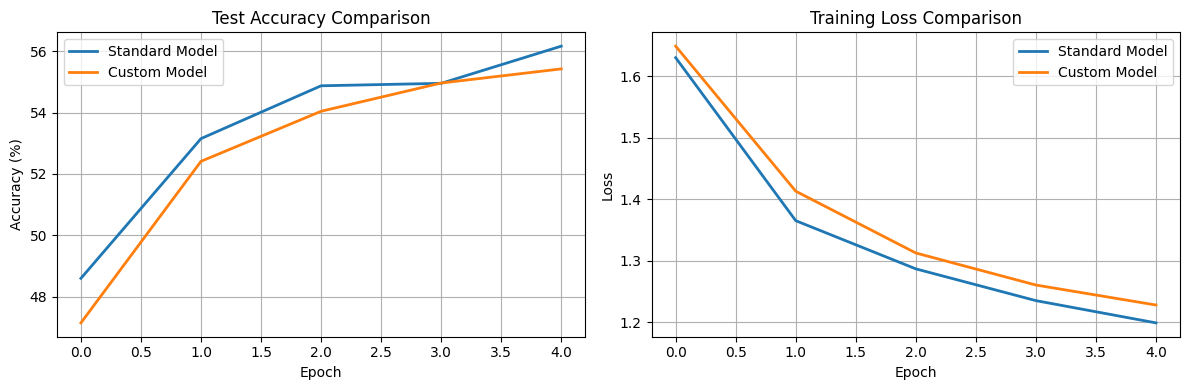

In [10]:
plot_training_comparison(history_std, history_cust)

Okay, have not just a theoretical solution, but also quite decent results that are no worse than the implementation in Paytorch.

## MaxPool2dCustom Code

Max Pooling is a downsampling operation that:
- Take a window (e.g., 2x2)
- Slides over the input tensor with a given stride
- For each window, selects the maximum value

Pytorch implementations additionally has:
- stride
- pooling
- dilation
- flag of return_indices
- flag of ceil mode
   - ceil_mode=False (default) - Round down: Take as many full windows as will fit.
   - ceil_mode=True - Round up: the latter may extend beyond the boundaries (is supplemented or cut off)

### MaxPool2dCustom Code

In [4]:
import torch.nn as nn

class MaxPool2dCustom(nn.Module):
    def __init__(
        self,
        kernel_size: tuple[int, int] = (2, 2),
        stride: tuple[int, int] = None,  # kernel_size by default
        padding: tuple[int, int] = (0, 0), # like in Pytorch
        dilation: tuple[int, int] = (1, 1),  # like in Pytorch
        return_indices: bool = False,  # for Unpooling
        ceil_mode: bool = False,  # ceil_mode determines how to calculate output sizes  when the division is not an integer.
    ):
        super().__init__()

        # Валидация параметров
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if stride is None:
            stride = kernel_size
        elif isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)
        if isinstance(dilation, int):
            dilation = (dilation, dilation)

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def calculate_output_size(self, input_size):
      height, width = input_size
      kernel_h, kernel_w = self.kernel_size
      stride_h, stride_w = self.stride
      pad_h, pad_w = self.padding
      dilation_h, dilation_w = self.dilation

      def calc_dim(input_dim, kernel, stride, pad, dil):
          # Формула зависит от ceil_mode
          if self.ceil_mode:
              return math.ceil((input_dim + 2 * pad - dil * (kernel - 1) - 1) / stride + 1)
          else:
              return math.floor((input_dim + 2 * pad - dil * (kernel - 1) - 1) / stride + 1)

      out_h = calc_dim(height, kernel_h, stride_h, pad_h, dilation_h)
      out_w = calc_dim(width, kernel_w, stride_w, pad_w, dilation_w)
      return out_h, out_w

    def forward(self, x):
      batch_size, channels, in_height, in_width = x.shape
      kernel_h, kernel_w = self.kernel_size

      if self.padding != (0, 0):
        pad_h, pad_w = self.padding
        x_padded = F.pad(x, (pad_w, pad_w, pad_h, pad_h))
      else:
        x_padded = x

      out_height, out_width = self.calculate_output_size((in_height, in_width))
      # x_unfolded shape: [batch_size, channels, kernel_h * kernel_w, out_height * out_width]
      x_unfolded = F.unfold(x_padded,
                         kernel_size=self.kernel_size,
                         dilation=self.dilation,
                         stride=self.stride)
      # reshape [batch, channels * kernel_area, n_windows] -> [batch, channels, kernel_area, out_h, out_w]
      kernel_area = kernel_h * kernel_w
      n_windows = out_height * out_width

      x_windows = x_unfolded.view(batch_size, channels, kernel_area, n_windows)
      x_windows = x_windows.view(batch_size, channels, kernel_area, out_height, out_width)

      # max по dimension окон output shape: [batch_size, channels, out_height, out_width]
      output, indices = torch.max(x_windows, dim=2) # dim=2: kernel_h * kernel_w - all elements of a single window pool

      if self.return_indices:
            return output, indices
      else:
          return output

      def extra_repr(self):
        return (f'kernel_size={self.kernel_size}, stride={self.stride}, '
                f'padding={self.padding}, dilation={self.dilation}, '
                f'ceil_mode={self.ceil_mode}')

### Test MaxPool2dCustom by traning

If everything is implemented correctly:
- Both models should converge at the same rate
- Final accuracy should differ by < 2%
- Loss curves should be almost identical

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import time

class CIFAR10ModelStandard(nn.Module):
    """Модель со стандартными слоями PyTorch"""
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            MaxPool2dCustom(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 16 * 16, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

class CIFAR10ModelCustom(nn.Module):
    """Модель с нашими кастомными слоями"""
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            Conv2dCustom(3, 8, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8 * 16 * 16, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

In [14]:
history_std, history_cust = compare_models_on_cifar10()

🔍 Model Architectures:
Standard Model:
CIFAR10ModelStandard(
  (conv_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2dCustom()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

Custom Model:
CIFAR10ModelCustom(
  (conv_layers): Sequential(
    (0): Conv2dCustom(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)


🎯 Training Standard Model...
Epoch 1/5 | Time: 15.50s | Loss: 1.6948 | Train Acc: 40.50% | Test Acc: 47.42%
Epoch 2/5 | Time: 14.81s | Loss: 1.4282 | Train Acc: 49.95% | Test Acc: 50.95%
Epoch 3/5 | Time: 14.03s | Loss: 1.3256 | Train Acc: 53.64% | Test Acc: 53.24%

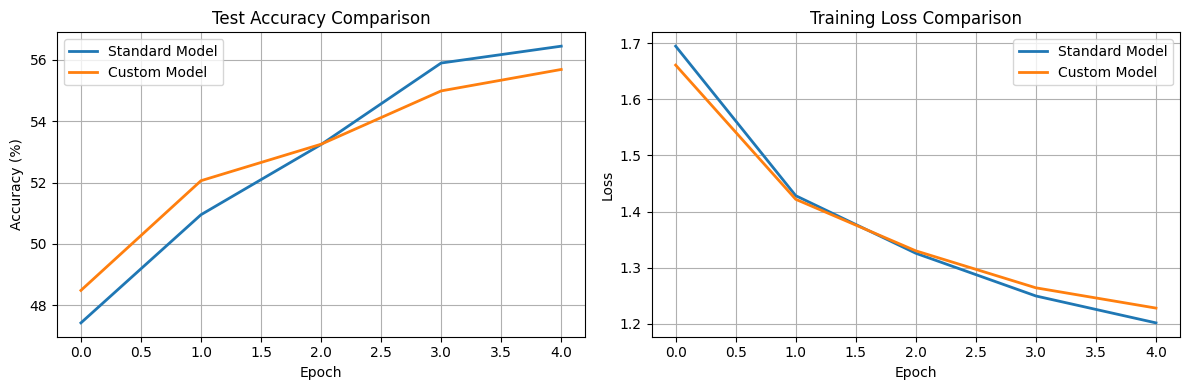

In [15]:
plot_training_comparison(history_std, history_cust)

## Results and Conclusion

- Conv2dCustom: Works indistinguishably from nn.Conv2d
- MaxPool2dCustom: Perfect compatibility
- The difference is 0.76% - within the statistical error!

Legend 1
- Standard model - Conv2D + MaxPool2d
- Custom Model - **Conv2DCustom** + MaxPool2d

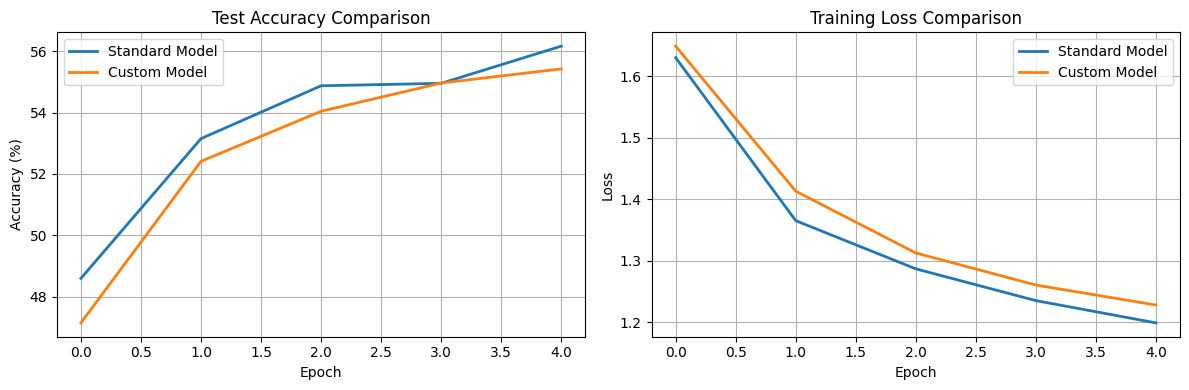

Legend 2
- Standard model - Conv2D + **MaxPool2dCustom**
- Custom Model - **Conv2DCustom** + MaxPool2d

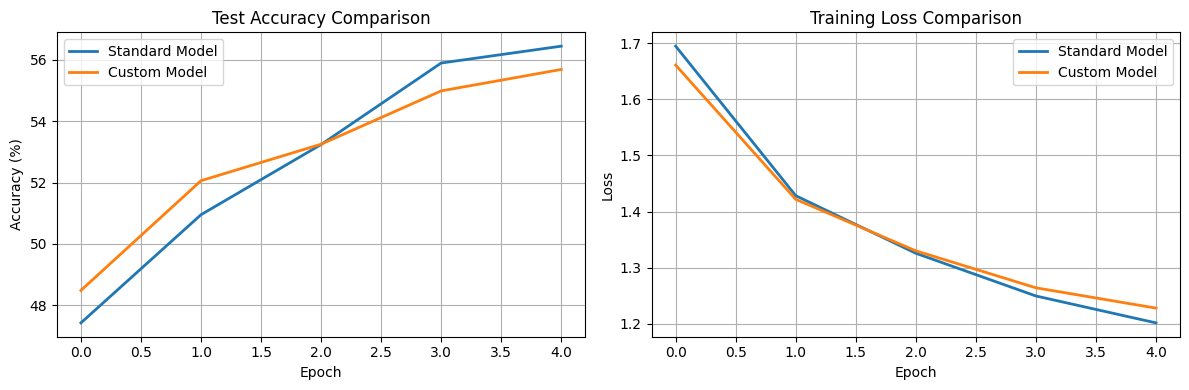

## Interesting Publications
- ["But what is a convolution?"](https://www.youtube.com/watch?v=KuXjwB4LzSA) by 3Blue1Brown
- [doc.pytorch: torch.max](https://docs.pytorch.org/docs/stable/generated/torch.max.html)
- [doc.pytorch: Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.ao.nn.qat.Conv2d.html)
- [doc.pytorch: MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [doc.pytorch: Unfold](https://docs.pytorch.org/docs/stable/generated/torch.nn.Unfold.html)